In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller

from py_pol import degrees

import matplotlib.pyplot as plt

from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field
from py_aocg.ifta.algorithms import distances_scalar

py_aocg
number of processors: 8
total memory        : 7.5 Gb
available memory    : 48 %
max frequency       : 4000 GHz
number of processors: 8
total memory        : 7.5 Gb
available memory    : 48 %
max frequency       : 4000 GHz


## Cargar Matrices de polarización de Holoeye

In [3]:
S_incident=Jones_vector('incident')
S_incident.circular_light(intensity=2)

Jslm=cargar_Jones_SLM(type="Jones")

In [4]:
Jslm = cargar_Jones_SLM()
print(Jslm.shape)

[256]


In [5]:
# angles_amplitude = [1.63644037, 5.11863528, 2.7111866,  1.68529409]
angles_phase     = [4.8175487,  0.01581232, 1.75758677, 1.15229228]
angles_spiral    = [0.85421954, 2.13133493, 4.81888539, 4.7449518 ]

- amplitud:       best cost: 0.21199592361665928, best pos: [1.63644037 5.11863528 2.7111866  1.68529409]
- fase    best cost: 0.21164481754171188, best pos: [1.61038889 1.947723   2.66072842 4.8141105 ]
- espiral:    best cost: 0.1860612974896374, best pos: [0.85421954 2.13133493 4.81888539 4.7449518 ]

Text(0.5, 0.98, 'amplitude')

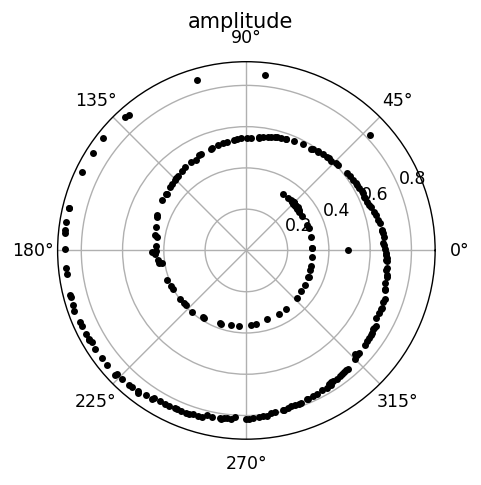

In [6]:
u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles_spiral, Jslm, E0=S_incident)
u_fab = u_fab_amplitude*np.exp(1j*2*u_fab_phase)

plt.polar(2*u_fab_phase,u_fab_amplitude, 'k.')
plt.suptitle('amplitude')

## Objetivo

In [7]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

In [8]:
num_x=128
num_y=128
DOE_size=40*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

In [9]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()

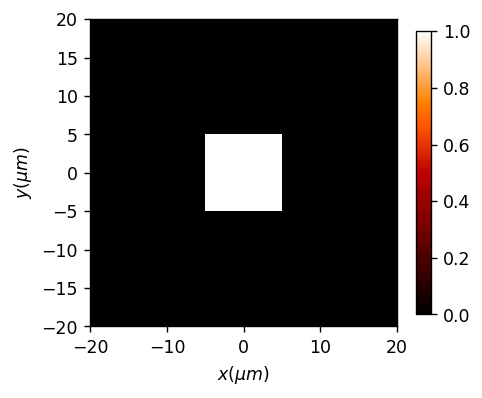

In [10]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(0,0), size=(10,10), angle=0)
target.draw(has_colorbar='vertical');

## IFTA fase estándar

Se realiza una optimización de distancias con IFTA estándard de fase

In [11]:
from py_aocg.ifta.algorithms import GS_scalar_Fresnel, verify_mask, compute_error, make_binary
from py_aocg.ifta.algorithms import mean_square_error, mnse
from py_aocg.ifta.algorithms import GS_scalar_far, GS_scalar_Fresnel, GS_far_algorithm_deprecated, GS_Fresnel_algorithm_deprecated

In [12]:
num_steps=150


CPU times: user 805 ms, sys: 4.49 ms, total: 810 ms
Wall time: 777 ms


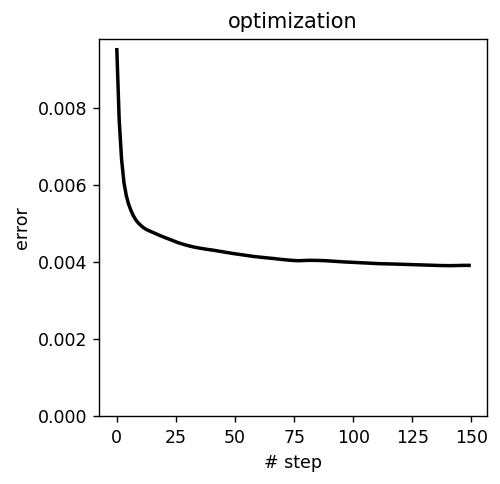

In [13]:
%%time
DOE_far_standard, mask_final_standard, errors_standard = GS_scalar_far(None,target, kind='phase', is_binary=False, phase=2*np.pi, num_steps=num_steps, has_draw=True)

In [14]:
print(errors_standard.min())

0.003916088778590884


(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7fa8341f5580>)

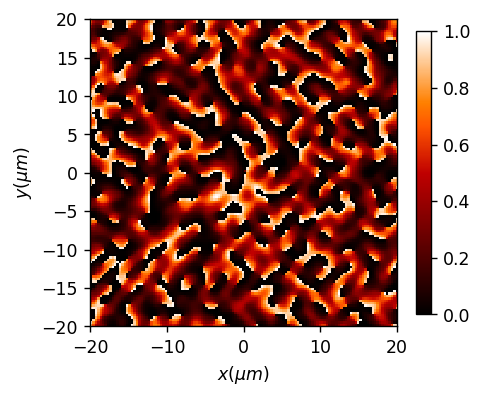

In [15]:
mask_final_standard.draw(has_colorbar='vertical')

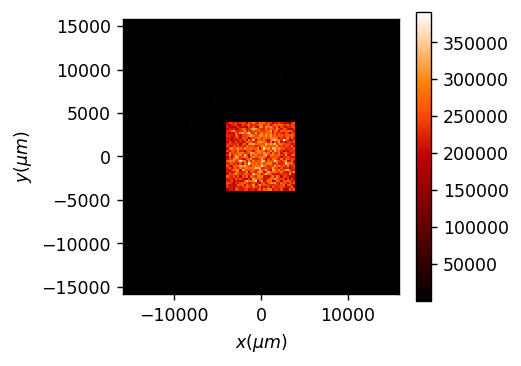

In [16]:
u_far_standard = DOE_far_standard.fft(new_field=True, remove0=False)
#u_far_standard.normalize()
u_far_standard.draw(has_colorbar='vertical', logarithm=0);

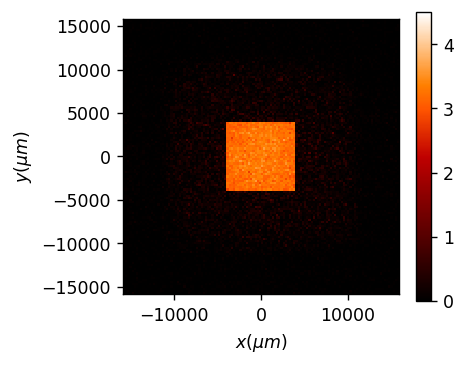

In [17]:
u_far_standard = DOE_far_standard.fft(new_field=True, remove0=False)
#u_far_standard.normalize()
u_far_standard.draw(has_colorbar='vertical', logarithm=1e-4 );
plt.clim(0,4.5)

## IFTA distancias bucle

Se realiza una optimización de distancias con IFTA minimizando las distancias

In [18]:
def GS_scalar_far(source,
                  target,
                  kind,
                  is_binary,
                  num_steps,
                  phase=np.pi,
                  has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        kind (str): 'phase' or 'amplitude'
        is_binary (bool): False or True
        num_steps (int): number of steps in the algorithm
        phase (float): phase for binary masks
        has_draw (bool): If True, draws the errors.

    Returns:
        DOE (Scalar_mask_XY): DOE which produces the algoritm
        mask_final (Scalar_mask_XY): mask of algorithm (for fabrication: 0-1).
        errors (np.array): Data of errors
    """
    

In [19]:
kind = 'phase'
phase=2*np.pi
is_binary=False
has_draw=True

In [20]:
    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    num_x = len(x)
    num_y = len(y)
    wavelength = target.wavelength

In [21]:
    if source is None:
        source = 1.

In [22]:
    DOE = Scalar_mask_XY(x, y, wavelength)
    far_field = Scalar_mask_XY(x, y, wavelength)

In [23]:
    target_abs = np.fft.fftshift(np.abs(target.u))
    far_field.u = target_abs * np.exp(1j * 2 * phase * np.random.rand(num_y, num_x))
    I_result = target_abs**2
    I_result = I_result/I_result.mean()

CPU times: user 30.5 s, sys: 4.6 s, total: 35.1 s
Wall time: 35 s


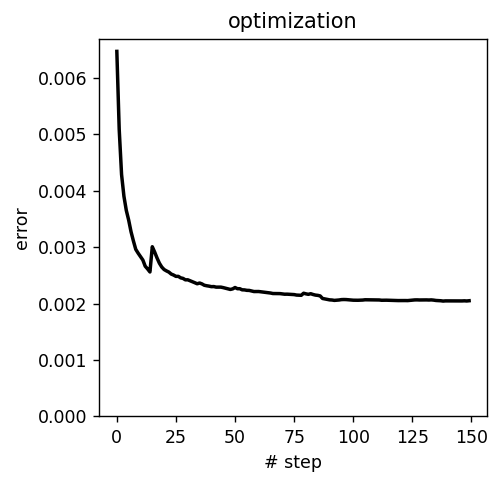

In [24]:
    %%time
    error_min=1000
    for i in range(num_steps):
        DOEu = far_field.ifft(shift=False, matrix=True, new_field=False)
        DOEu = DOEu / DOEu.max()

        DOE_new, i_positions, distances = distances_scalar(DOEu, u_fab)

        DOEu = DOE_new
        mask= DOEu
        
        DOE.u = DOEu
        field_z = DOE.fft(shift=False, matrix=True)
        field_z = field_z / field_z.max()
        far_field.u = target_abs * np.exp(1j * np.angle(field_z))

        I_z = np.abs(field_z)**2
        #I_z = I_z / I_z.mean()

        error = mnse(I_result, I_z)
        print("{}/{} - error {:2.6f} %".format(i, num_steps, error), end='\r')
        errors[i] = error
        
        if error < error_min:
            error_min == error
            DOE_final = DOE

    mask = np.fft.fftshift(mask)
    if kind == 'phase':
        mask = (mask + np.pi) / (2 * np.pi)
    elif kind == 'amplitude':
        mask = mask / mask.max()

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    if has_draw:
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

In [25]:
#return DOE, mask_final, errors

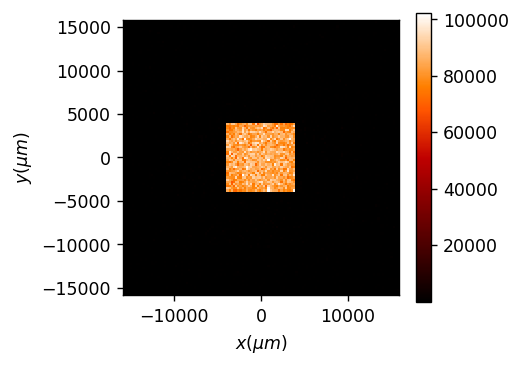

In [26]:
u_far_new = DOE_final.fft(new_field=True, remove0=False)
#u_far_new.normalize()
u_far_new.draw(has_colorbar='vertical', logarithm=0);

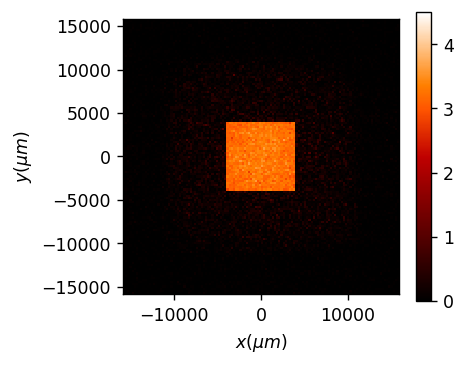

In [27]:
u_far_new = DOE_final.fft(new_field=True, remove0=False)
#u_far_new.normalize()
u_far_standard.draw(has_colorbar='vertical', logarithm=1e-4 );
plt.clim(0,4.5)

In [28]:
print(i_positions.max(), i_positions.min())

255 0


(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7fa83411e670>)

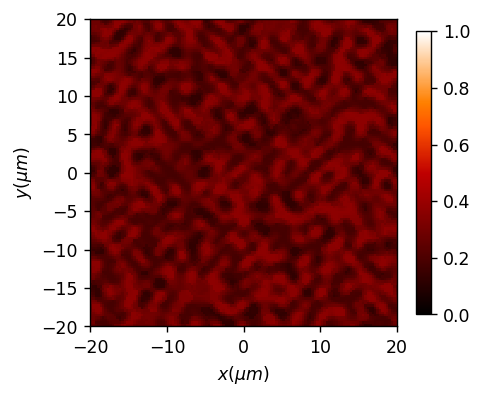

In [29]:
mask_final.draw(has_colorbar='vertical')

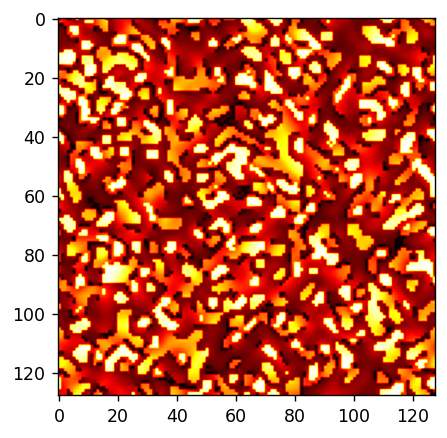

In [30]:
plt.imshow(i_positions, cmap='hot')

In [31]:
100*np.abs((errors.min()-errors_standard.min())/errors_standard.min())

47.79052399856181

## Analisis de errores

**Hay que solucionar el problema de que al dar la vuelta a la inversa no se recuera intensidad 1**

In [32]:
I_standard=u_far_standard.intensity()
I_standard=I_standard/I_standard.max()
I_new=u_far_new.intensity()
I_new=I_new/I_new.max()
I_target=target.intensity()
i_target_up=target.u>0.5
i_target_down=target.u<0.5

## 

In [33]:
I_standard[i_target_up].mean()/I_target.mean(), I_new[i_target_up].mean()/I_target.mean()

(10.175323484545782, 13.193549735386974)

In [34]:
I_standard[i_target_down].mean(), I_new[i_target_down].mean()

(0.0023425447395387248, 0.0017429806092253794)

In [35]:
np.std(I_standard[i_target_down]), np.std(I_new[i_target_down])

(0.0037139328273403443, 0.0018362532690796352)

In [36]:
np.std(I_standard[i_target_up]), np.std(I_new[i_target_up])

(0.0984401330968607, 0.060504413956767485)

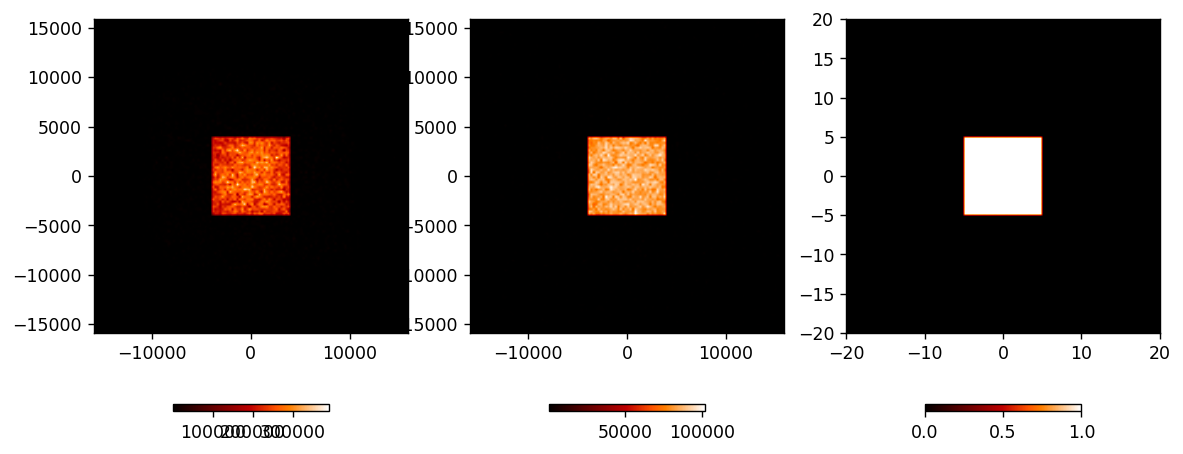

In [37]:
draw_several_fields((u_far_standard, u_far_new, target))